In [1]:
!pip install pybullet
!pip install ptan
!pip install tensorboardX

from google.colab import drive
drive.mount('./mount')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at ./mount


In [2]:
import ptan
import numpy as np
import torch
import torch.nn as nn
import torch.distributions as distr

HID_SIZE = 64


class ModelActor(nn.Module):
    def __init__(self, obs_size, act_size):
        super(ModelActor, self).__init__()

        self.base = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, HID_SIZE),
            nn.ReLU(),
        )
        self.mu = nn.Sequential(
            nn.Linear(HID_SIZE, act_size),
        )
        self.var = nn.Sequential(
            nn.Linear(HID_SIZE, act_size),
            nn.Softplus(),
        )

    def forward(self, x):
        base_out = self.base(x)
        act_dist = distr.Normal(self.mu(base_out), self.var(base_out))
        normal_sample = act_dist.rsample()
        acts_v = torch.tanh(normal_sample)
        log_prob = act_dist.log_prob(normal_sample)
        log_prob -= torch.log(1-acts_v.pow(2) + 1e-7)
        return acts_v, log_prob


class ModelCritic(nn.Module):
    def __init__(self, obs_size):
        super(ModelCritic, self).__init__()

        self.value = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, 1),
        )

    def forward(self, x):
        return self.value(x)


class ModelSACTwinQ(nn.Module):
    def __init__(self, obs_size, act_size):
        super(ModelSACTwinQ, self).__init__()

        self.q1 = nn.Sequential(
            nn.Linear(obs_size + act_size, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, 1),
        )

        self.q2 = nn.Sequential(
            nn.Linear(obs_size + act_size, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, 1),
        )

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=1)
        return self.q1(x), self.q2(x)


class AgentA2C(ptan.agent.BaseAgent):
    def __init__(self, net, device="cpu"):
        self.net = net
        self.device = device

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states)
        states_v = states_v.to(self.device)

        actions, _ = self.net(states_v)
        actions = actions.data.cpu().numpy()

        return actions, agent_states


class AlphaAdapt:
    def __init__(self, target_entropy, INIA_ENTROPY_ALPHA, LR_ALPHA):
        self.target_entropy = target_entropy
        self.log_alpha = torch.tensor(np.log(INIA_ENTROPY_ALPHA), dtype=torch.float)
        self.log_alpha.requires_grad = True
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=LR_ALPHA)

    def train(self, entropy):
        self.log_alpha_optimizer.zero_grad()
        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        alpha_loss.backward()
        self.log_alpha_optimizer.step()  


def test_net(net, env, count=10, device="cpu"):
    rewards = 0.0
    steps = 0
    for _ in range(count):
        obs = env.reset()
        while True:
            obs_v = ptan.agent.float32_preprocessor([obs])
            obs_v = obs_v.to(device)

            actions, _ = net(obs_v)
            actions = actions.data.cpu().numpy().squeeze()

            obs, reward, done, _ = env.step(actions)

            rewards += reward
            steps += 1
            if done:
                break
    return rewards / count, steps / count


def unpack_batch_a2c(batch, net, last_val_gamma, device="cpu"):
    """
    Convert batch into training tensors
    :param batch:
    :param net:
    :return: states variable, actions tensor, reference values variable
    """
    states = []
    actions = []
    rewards = []
    not_done_idx = []
    last_states = []
    for idx, exp in enumerate(batch):
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        if exp.last_state is not None:
            not_done_idx.append(idx)
            last_states.append(exp.last_state)
    states_v = ptan.agent.float32_preprocessor(states).to(device)
    actions_v = torch.FloatTensor(actions).to(device)

    # handle rewards
    rewards_np = np.array(rewards, dtype=np.float32)
    if not_done_idx:
        last_states_v = ptan.agent.float32_preprocessor(last_states).to(device)
        last_vals_v = net(last_states_v)
        last_vals_np = last_vals_v.data.cpu().numpy()[:, 0]
        rewards_np[not_done_idx] += last_val_gamma * last_vals_np

    ref_vals_v = torch.FloatTensor(rewards_np).to(device)
    return states_v, actions_v, ref_vals_v


@torch.no_grad()
def unpack_batch_sac(batch, val_net, twinq_net, policy_net,
                     gamma: float, ent_alpha: float,
                     device="cpu"):
    """
    Unpack Soft Actor-Critic batch
    """
    states_v, actions_v, ref_q_v = \
        unpack_batch_a2c(batch, val_net, gamma, device)

    # references for the critic network
    acts_v, log_prob = policy_net(states_v)
    q1_v, q2_v = twinq_net(states_v, acts_v)
    # element-wise minimum
    ref_vals_v = torch.min(q1_v, q2_v).squeeze() - \
                 ent_alpha * log_prob.sum(dim=1)
    return states_v, actions_v, ref_vals_v, ref_q_v

In [3]:
# cuda or not
import torch

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:",torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda: Tesla P100-PCIE-16GB


device(type='cuda')

In [4]:
import os
import ptan
import gym
import math
import time
import pybullet_envs
# import argparse
from tensorboardX import SummaryWriter
import numpy as np

# from lib import model, common, test_net

import torch
import torch.optim as optim
import torch.distributions as distrib
import torch.nn.functional as F


ENV_ID = "MinitaurBulletEnv-v0"
GAMMA = 0.99
BATCH_SIZE = 64
LR_ACTS = 1e-4
LR_VALS = 1e-4
LR_ALPHA = 1e-4
REPLAY_SIZE = 100000
REPLAY_INITIAL = 10000
INIA_ENTROPY_ALPHA = 1e-2

TEST_ITERS = 10000


save_path = os.path.join('mount/My Drive/Colab Notebooks/minitaur_', '05_22060616_SAC')
os.makedirs(save_path, exist_ok=True)

env = gym.make(ENV_ID)
test_env = gym.make(ENV_ID)

act_net = ModelActor(
    env.observation_space.shape[0],
    env.action_space.shape[0]).to(device)
crt_net = ModelCritic(
    env.observation_space.shape[0]
).to(device)
twinq_net = ModelSACTwinQ(
    env.observation_space.shape[0],
    env.action_space.shape[0]).to(device)
print(act_net)
print(crt_net)
print(twinq_net)

tgt_crt_net = ptan.agent.TargetNet(crt_net)

writer = SummaryWriter(comment="-sac_")
agent = AgentA2C(act_net, device=device)
exp_source = ptan.experience.ExperienceSourceFirstLast(
    env, agent, gamma=GAMMA, steps_count=1)
buffer = ptan.experience.ExperienceReplayBuffer(
    exp_source, buffer_size=REPLAY_SIZE)
act_opt = optim.Adam(act_net.parameters(), lr=LR_ACTS)
crt_opt = optim.Adam(crt_net.parameters(), lr=LR_VALS)
twinq_opt = optim.Adam(twinq_net.parameters(), lr=LR_VALS)

alpha_optim = AlphaAdapt(torch.tensor(-env.action_space.shape[0], dtype=torch.float), INIA_ENTROPY_ALPHA, LR_ALPHA)


current_dir=/usr/local/lib/python3.7/dist-packages/pybullet_envs/bullet
urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data
urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


ModelActor(
  (base): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (mu): Sequential(
    (0): Linear(in_features=64, out_features=8, bias=True)
  )
  (var): Sequential(
    (0): Linear(in_features=64, out_features=8, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
)
ModelCritic(
  (value): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
ModelSACTwinQ(
  (q1): Sequential(
    (0): Linear(in_features=36, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (q2): Sequential(
    (0): Linear(in_features=36, out_features=64, bias=True)
    (1): ReLU()
  

In [ ]:
frame_idx = 0
best_reward = None
with ptan.common.utils.RewardTracker(writer) as tracker:
    with ptan.common.utils.TBMeanTracker(
            writer, batch_size=10) as tb_tracker:
        while True:
            frame_idx += 1
            buffer.populate(1)
            rewards_steps = exp_source.pop_rewards_steps()
            if rewards_steps:
                rewards, steps = zip(*rewards_steps)
                tb_tracker.track("episode_steps", steps[0], frame_idx)
                tracker.reward(rewards[0], frame_idx)

            if len(buffer) < REPLAY_INITIAL:
                continue

            batch = buffer.sample(BATCH_SIZE)
            states_v, actions_v, ref_vals_v, ref_q_v = \
                unpack_batch_sac(
                    batch, tgt_crt_net.target_model,
                    twinq_net, act_net, GAMMA,
                    alpha_optim.log_alpha.exp(), device)

            tb_tracker.track("ref_v", ref_vals_v.mean(), frame_idx)
            tb_tracker.track("ref_q", ref_q_v.mean(), frame_idx)

            ####

            # Critic
            crt_opt.zero_grad()
            val_v = crt_net(states_v)
            v_loss_v = F.mse_loss(val_v.squeeze(),
                                  ref_vals_v.detach())
            v_loss_v.backward()
            crt_opt.step()
            tb_tracker.track("loss_v", v_loss_v, frame_idx)

            # train TwinQ
            twinq_opt.zero_grad()
            q1_v, q2_v = twinq_net(states_v, actions_v)
            q1_loss_v = F.mse_loss(q1_v.squeeze(),
                                    ref_q_v.detach())
            q2_loss_v = F.mse_loss(q2_v.squeeze(),
                                    ref_q_v.detach())
            q_loss_v = q1_loss_v + q2_loss_v
            q_loss_v.backward()
            twinq_opt.step()
            tb_tracker.track("loss_q1", q1_loss_v, frame_idx)
            tb_tracker.track("loss_q2", q2_loss_v, frame_idx)

            # Actor
            acts_v, log_prob = act_net(states_v)
            q1_v, q2_v = twinq_net(states_v, acts_v)
            entropy = -log_prob.sum(dim=1)
            LLLL = torch.min(q1_v, q2_v).squeeze() + alpha_optim.log_alpha.exp() * entropy
            act_opt.zero_grad()
            act_loss = -LLLL.mean()
            act_loss.backward()
            act_opt.step()
            tb_tracker.track("loss_act", act_loss, frame_idx)

            alpha_optim.train(entropy)

            tgt_crt_net.alpha_sync(alpha=1 - 1e-3)

            if frame_idx % TEST_ITERS == 0:

                print('EEEE', entropy.mean())
                print('QQQQQQQQQQQQ', -q1_v.mean())
                print('AAAAAAAAAAAAAAAAAAAA', alpha_optim.log_alpha.exp())

                ts = time.time()
                rewards, steps = test_net(act_net, test_env, device=device)
                print("Test done in %.2f sec, reward %.3f, steps %d" % (
                    time.time() - ts, rewards, steps))
                writer.add_scalar("test_reward", rewards, frame_idx)
                writer.add_scalar("test_steps", steps, frame_idx)
                if best_reward is None or best_reward < rewards:
                    if best_reward is not None:
                        print("Best reward updated: %.3f -> %.3f" % (best_reward, rewards))
                        name = "best_%+.3f_%d.dat" % (rewards, frame_idx)
                        fname = os.path.join(save_path, name)
                        torch.save(act_net.state_dict(), fname)
                    best_reward = rewards


流式输出内容被截断，只能显示最后 5000 行内容。
109394: done 1096 episodes, mean reward 0.117, speed 48.26 f/s
109446: done 1097 episodes, mean reward 0.117, speed 49.97 f/s
109500: done 1098 episodes, mean reward 0.119, speed 50.35 f/s
109594: done 1100 episodes, mean reward 0.120, speed 49.97 f/s
109670: done 1102 episodes, mean reward 0.122, speed 48.11 f/s
109778: done 1104 episodes, mean reward 0.124, speed 50.06 f/s
109834: done 1105 episodes, mean reward 0.125, speed 50.93 f/s
109902: done 1107 episodes, mean reward 0.127, speed 47.03 f/s
109985: done 1109 episodes, mean reward 0.127, speed 49.27 f/s
EEEE tensor(-7.9255, grad_fn=<MeanBackward0>)
QQQQQQQQQQQQ tensor(-0.1229, grad_fn=<NegBackward>)
AAAAAAAAAAAAAAAAAAAA tensor(6.1858e-05, grad_fn=<ExpBackward>)
Test done in 15.86 sec, reward 0.099, steps 233
110023: done 1110 episodes, mean reward 0.128, speed 2.28 f/s
110117: done 1112 episodes, mean reward 0.133, speed 49.49 f/s
110168: done 1113 episodes, mean reward 0.133, speed 49.78 f/s
110349: d

In [1]:
save_path_act = os.path.join(save_path, 'act_net.pth')
save_path_crt = os.path.join(save_path, 'crt_net.pth')
save_path_twinq = os.path.join(save_path, 'twinq_net.pth')

torch.save(act_net.state_dict(), save_path_act)
torch.save(crt_net.state_dict(), save_path_crt)
torch.save(twinq_net.state_dict(), save_path_twinq)

NameError: ignored

In [6]:
XXXX = torch.load('mount/My Drive/Colab Notebooks/minitaur_/05_22060616_SAC/best_+10.847_450000.dat')

In [9]:
# video recorder import
from gym.wrappers.monitoring.video_recorder import VideoRecorder


# video -> html function
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'


# setup env & download model

env = gym.make("MinitaurBulletEnv-v0")

net = ModelActor(env.observation_space.shape[0], env.action_space.shape[0])
net.load_state_dict(XXXX)


# video record

minitaur_training = "minitaur_training.mp4"
video = VideoRecorder(env, minitaur_training)

steps = 0
rewards = 0

state = env.reset()
done = False
while not done:
  env.render()
  video.capture_frame()

  state = torch.tensor(state, dtype=torch.float)
  # action, _ = net(state)
  action = net.base(state)
  action = net.mu(action)
  action = torch.tanh(action)

  action = action.squeeze(dim=0).data.cpu().numpy()
  action = np.clip(action, -1, 1)
  next_state, reward, done, info = env.step(action)

  state = next_state
  steps += 1
  rewards += reward

  pass

env.render()
video.capture_frame()

video.close()
env.close()


# video play

print('steps:', steps)
print('rewards:', rewards)
from IPython.display import HTML
html = render_mp4(minitaur_training)
HTML(html)

Output hidden; open in https://colab.research.google.com to view.

urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


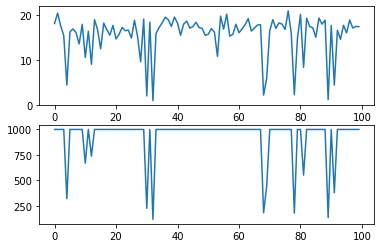

In [8]:
CYCLE = 100

# setup env & download model

env = gym.make("MinitaurBulletEnv-v0")

net = ModelActor(env.observation_space.shape[0], env.action_space.shape[0])
net.load_state_dict(XXXX)


# simulate

rewords_by_episodes = []
steps_by_episodes = []

for i in range(CYCLE):
  
  rewords = 0
  steps = 0

  state = env.reset()
  done = False
  while not done:

    state = torch.tensor(state, dtype=torch.float)
    # action, _ = net(state)
    action = net.base(state)
    action = net.mu(action)
    action = torch.tanh(action)
    
    action = action.squeeze(dim=0).data.cpu().numpy()
    action = np.clip(action, -1, 1)
    next_state, reword, done, info = env.step(action)

    state = next_state
    rewords += reword
    steps += 1

    pass

  rewords_by_episodes.append(rewords)
  steps_by_episodes.append(steps)

  pass

env.close()


# plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots(2)
ax[0].plot(rewords_by_episodes)
ax[1].plot(steps_by_episodes)